# Understanding Bias in Data and Models

**Dataset:** Women in Data Science (91,713 encounters)  
**Task:** Understanding Data Bias
**Date Updated:** March 3, 2025  
**Authors:** Jeremy Balch & Mackenzie Meni


### Introduction

This notebook will walk you through the process of understanding bias in data and models. We will use two datasets from the Women in Data Science (WiDS) dataset. The first dataset is the original and the second is an altered version that artificially introduces more bias through increased mortality rates in specific subgroups to illustrate the impact of bias on model performance.


### Import Libraries

Libraries are packages of pre-written code that we can use to create our own code. We will use the following libraries in this notebook:

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tableone import TableOne
import warnings
from sklearn.model_selection import train_test_split
import joblib
import seaborn as sns
from sklearn.metrics import roc_auc_score

warnings.filterwarnings("ignore")


## Load all data

This code loads the original and altered datasets, as well as the trained models.

In [39]:
# Loading original dataset
original_data = pd.read_csv('../preprocessed_data.csv')

# Loading altered dataset
data_altered_complete = pd.read_csv('../data_altered_complete.csv')

# Random Forest Original
original_rf_loaded = joblib.load("../original_data_random_forest_model.pkl")

# Random Forest Altered 20% African American
altered_rf_loaded = joblib.load("../altered_rf_model.pkl")



# Bootstrapping Model Performance: What It Shows

This analysis uses bootstrapping to measure the stability (how often the model gives the same result) and uncertainty (how much the model's performance varies across different samples) of our model’s performance. By repeatedly resampling the test data, we generate confidence intervals (CIs) for AUROC and Accuracy, helping us:

-  **Compare multiple models fairly** → Shows how consistently each model performs across different samples.
-  **Visualize uncertainty** → Narrower distributions mean more reliable models, while wider distributions indicate higher variability.
-  **Identify trade-offs** → If a debiased model has lower AUROC but better fairness, bootstrapping helps justify the trade-off.

**Why It Matters:**
Instead of relying on a single test result, bootstrapping ensures our conclusions hold across different samples, making our evaluation more robust and trustworthy.

Bootstrapping Random Forest...
Bootstrapping Altered Random Forest...


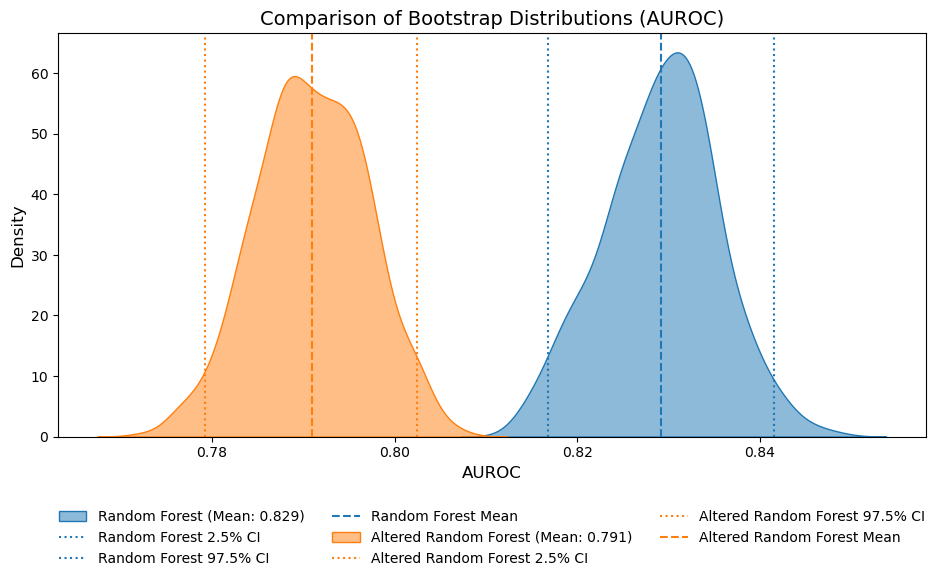

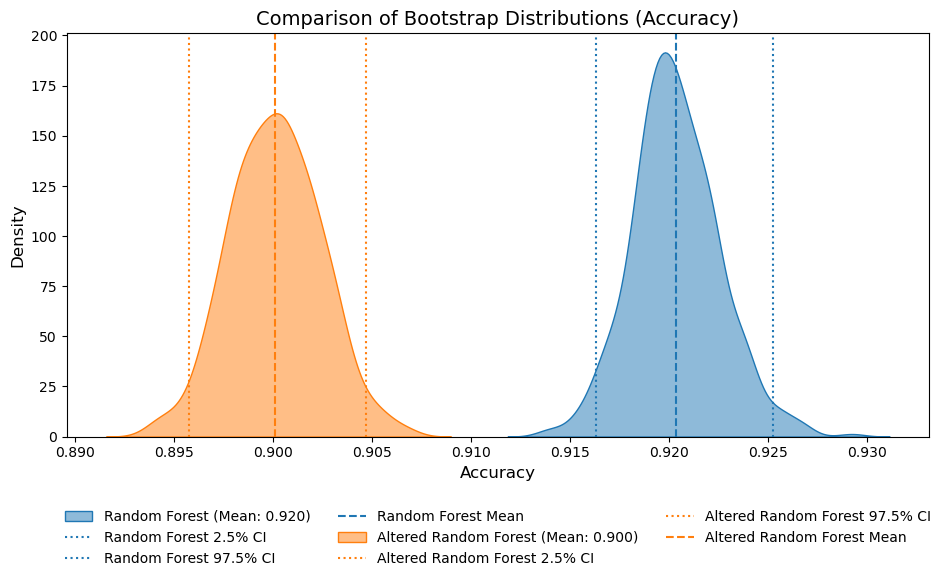

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import accuracy_score, roc_auc_score

# Ensure the same features are used as in training
expected_features = altered_rf_loaded.feature_names_in_  # Get the features used during training
print(expected_features)

# Drop the 'gender_M' and 'ethnicity_Other' columns
original_data = original_data.drop(columns=['gender_M', 'ethnicity_Other/Unknown'])

# Define your features and target variable
X = original_data.drop('hospital_death', axis=1)  # Features
y = original_data['hospital_death']               # Target variable

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# **🚀 Compute Bootstrap Distributions for Accuracy & AUROC**
def compute_bootstrap_scores(model, X_test, y_test, n_bootstraps=500):
    """Compute bootstrapped Accuracy and AUROC scores."""
    y_pred_full = model.predict(X_test)
    y_pred_proba_full = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    y_test_np = y_test.to_numpy()

    def bootstrap_metric(metric_func, y_pred, use_proba=False):
        def compute_bootstrap(_):
            indices = np.random.choice(len(y_test_np), len(y_test_np), replace=True)
            return metric_func(y_test_np[indices], y_pred[indices])

        return joblib.Parallel(n_jobs=-1)(
            joblib.delayed(compute_bootstrap)(_) for _ in range(n_bootstraps)
        )

    accuracy_scores = bootstrap_metric(accuracy_score, y_pred_full)
    auroc_scores = bootstrap_metric(roc_auc_score, y_pred_proba_full, use_proba=True) if y_pred_proba_full is not None else None

    return accuracy_scores, auroc_scores

# **🚀 Compute Bootstraps for Each Model**
bootstrapped_results = {}

for model, name in zip([original_rf_loaded, altered_rf_loaded], ["Random Forest", "Altered Random Forest"]):
    print(f"Bootstrapping {name}...")
    accuracy_scores, auroc_scores = compute_bootstrap_scores(model, X_test, y_test)
    bootstrapped_results[name] = {"Accuracy": accuracy_scores, "AUROC": auroc_scores}

# **🚀 Plot Both Accuracy & AUROC**
def plot_bootstrap_comparison(bootstrapped_results, metric_name):
    """Compare the bootstrap distributions of a given metric across multiple models."""
    plt.figure(figsize=(10, 6))
    colors = sns.color_palette("tab10", len(bootstrapped_results))

    for (model_name, scores_dict), color in zip(bootstrapped_results.items(), colors):
        scores = scores_dict[metric_name]
        if scores is None:
            continue  # Skip if metric is not available

        lower_ci = np.percentile(scores, 2.5)
        upper_ci = np.percentile(scores, 97.5)
        mean_value = np.mean(scores)

        # Plot KDE curve
        sns.kdeplot(scores, label=f"{model_name} (Mean: {mean_value:.3f})", fill=True, color=color, alpha=0.5)

        # Add CI and Mean lines
        plt.axvline(lower_ci, color=color, linestyle='dotted', label=f"{model_name} 2.5% CI")
        plt.axvline(upper_ci, color=color, linestyle='dotted', label=f"{model_name} 97.5% CI")
        plt.axvline(mean_value, color=color, linestyle='dashed', label=f"{model_name} Mean")

    # Labels & Formatting
    plt.xlabel(metric_name, fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.title(f"Comparison of Bootstrap Distributions ({metric_name})", fontsize=14)
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=10, frameon=False)
    plt.tight_layout()
    plt.show()

# **🚀 Generate Plots**
plot_bootstrap_comparison(bootstrapped_results, "AUROC")
plot_bootstrap_comparison(bootstrapped_results, "Accuracy")


## Assessing Model Fairness: AUROC by Subgroup 


This analysis evaluates model fairness by calculating the AUROC (Area Under the Receiver Operating Characteristic Curve) for different demographic subgroups. Instead of measuring overall performance, we analyze whether the model performs equally well across different groups.

**What This Does**
- Computes AUROC for each subgroup → Ethnicity, Gender, Age, and BMI.
- Identifies disparities in predictive performance → Some groups may have significantly lower AUROC.
- Visualizes results with bar plots → A clear way to compare performance gaps across subgroups.

**Why This Matters**
- If AUROC is lower for certain groups, it suggests the model may be biased or less effective for them.
- Fairer models should have similar AUROC across all subgroups.
- Helps justify debiasing techniques and guides model improvements.


In [43]:
# Same helper function for ethnicity / age / BMI
def calculate_auroc_by_group(data, group_columns, model, X_test, y_test):
    auroc_scores_else = {}
    for group_column in group_columns:
        # Filter the test set for the current group
        group_indices = (X_test[group_column] == 1)
        X_group = X_test[group_indices]
        y_group = y_test[group_indices]
        
        # Calculate AUROC if the group has enough samples
        if len(y_group) > 0:
            y_pred_proba_group = model.predict_proba(X_group)[:, 1]
            auroc_scores_else[group_column] = roc_auc_score(y_group, y_pred_proba_group)
    
    return auroc_scores_else


# Helper function for a single gender column (by default "gender_F")
def calculate_auroc_for_gender(model, X_test, y_test, gender_column='gender_F'):
    auroc_scores_by_gender = {}

    # Females
    female_indices = (X_test[gender_column] == 1)
    X_female = X_test[female_indices]
    y_female = y_test[female_indices]
    if len(y_female) > 0:
        y_pred_proba_female = model.predict_proba(X_female)[:, 1]
        auroc_scores_by_gender['Female'] = roc_auc_score(y_female, y_pred_proba_female)

    # Males
    male_indices = (X_test[gender_column] == 0)
    X_male = X_test[male_indices]
    y_male = y_test[female_indices == False]  # or simply y_test[male_indices]
    if len(y_male) > 0:
        y_pred_proba_male = model.predict_proba(X_male)[:, 1]
        auroc_scores_by_gender['Male'] = roc_auc_score(y_male, y_pred_proba_male)

    return auroc_scores_by_gender

## Using Subgroup Functions

AUROC by Ethnicity: {'ethnicity_African American': 0.5130968902987693, 'ethnicity_Asian': 0.8110526315789474, 'ethnicity_Caucasian': 0.8285162632117408, 'ethnicity_Hispanic': 0.8633478291365645, 'ethnicity_Native American': 0.9429245283018868}
AUROC by Gender: {'Female': 0.8359157431114609, 'Male': 0.8469455048278633}
AUROC by Age: {'age_cat_10-19': 0.8955026455026455, 'age_cat_20-29': 0.9024084923138551, 'age_cat_30-39': 0.9117472998964343, 'age_cat_40-49': 0.8803411528378332, 'age_cat_50-59': 0.8727072633895818, 'age_cat_60-69': 0.842381873714696, 'age_cat_70-79': 0.8116930593931778, 'age_cat_80-89': 0.7668904041480218}
AUROC by BMI: {'bmi_cat_10-14': 0.6788375558867362, 'bmi_cat_15-19': 0.7850106334277883, 'bmi_cat_20-24': 0.8302832706984034, 'bmi_cat_25-29': 0.8547825057302106, 'bmi_cat_30-34': 0.853546224417784, 'bmi_cat_35-39': 0.846559951414194, 'bmi_cat_40-44': 0.8624626818268437, 'bmi_cat_>45': 0.8323613340467274}


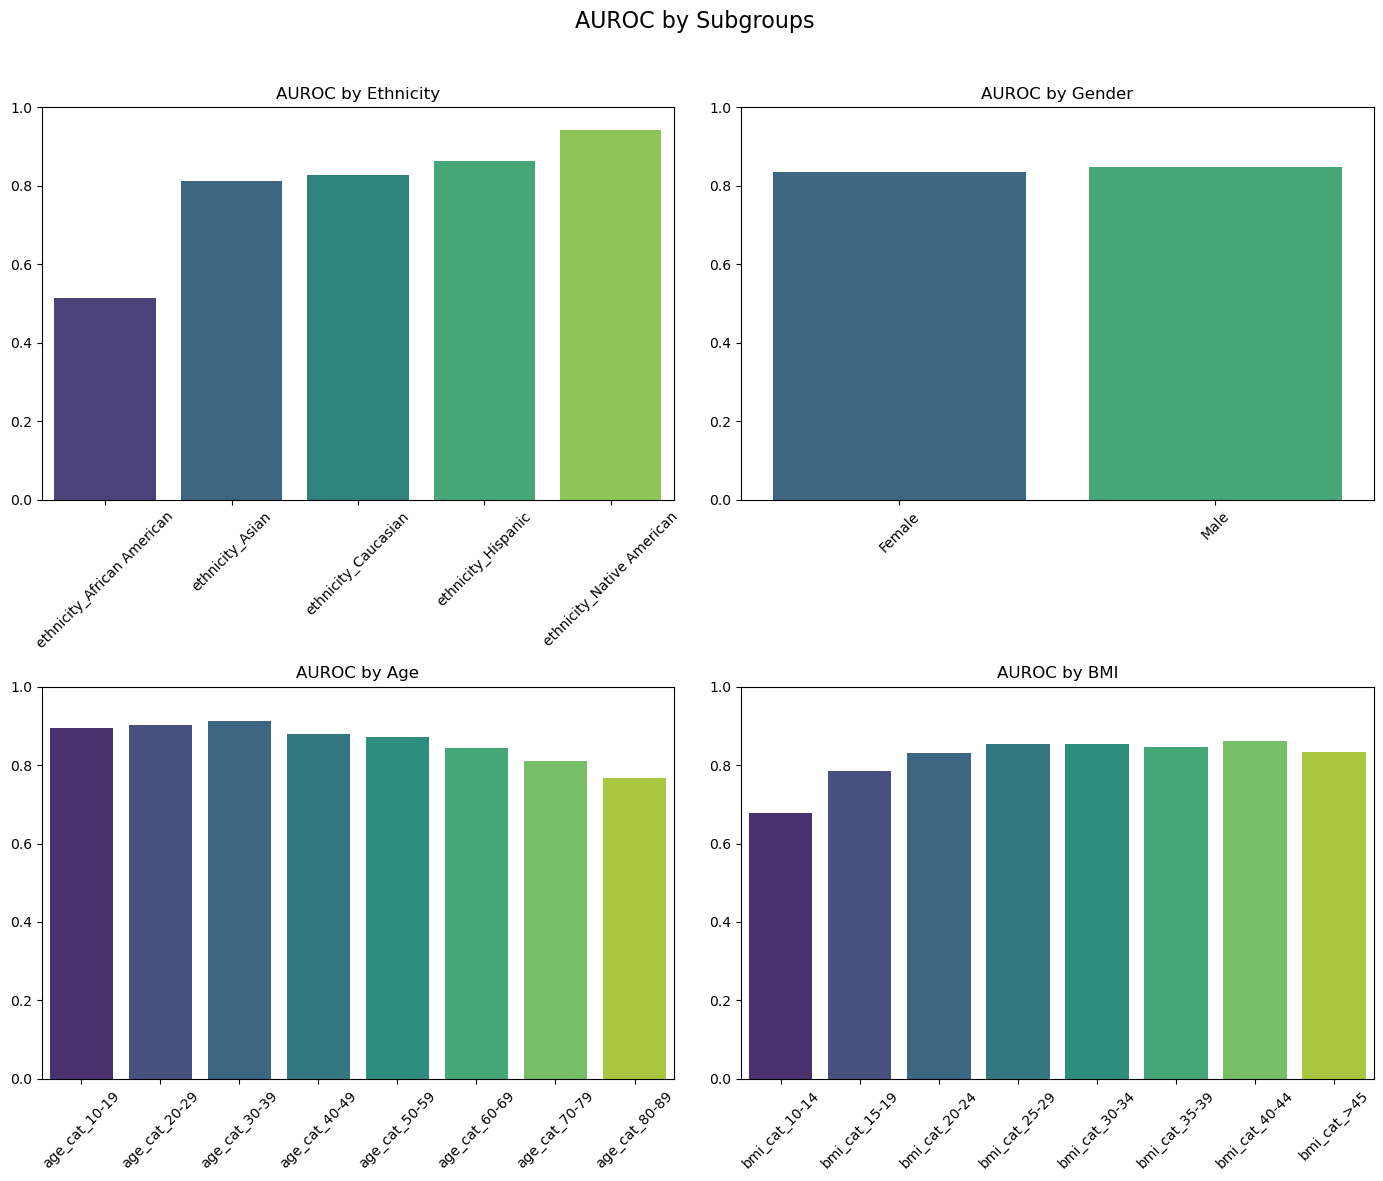

In [44]:
# Choose the model you want to explore
model_of_interest = altered_rf_loaded  # Any model you want to explore
data = data_altered_complete

# Drop the 'gender_M' and 'ethnicity_Other' columns
data = data.drop(columns=['gender_M', 'ethnicity_Other/Unknown'])

# Define your features and target variable
X = data.drop('hospital_death', axis=1)  # Features
y = data['hospital_death']               # Target variable

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Example subgroup columns
ethnicity_columns = [
    'ethnicity_African American',
    'ethnicity_Asian',
    'ethnicity_Caucasian',
    'ethnicity_Hispanic',
    'ethnicity_Native American'
]

age_columns = [
    'age_cat_10-19', 'age_cat_20-29', 'age_cat_30-39',
    'age_cat_40-49', 'age_cat_50-59', 'age_cat_60-69',
    'age_cat_70-79', 'age_cat_80-89'
]

bmi_columns = [
    'bmi_cat_10-14', 'bmi_cat_15-19', 'bmi_cat_20-24', 'bmi_cat_25-29',
    'bmi_cat_30-34', 'bmi_cat_35-39', 'bmi_cat_40-44', 'bmi_cat_>45'
]

data['gender_M'] = 1 - data['gender_F']  # only if "gender_F" exists!

# Now calculate AUROC for each subgroup
auroc_by_ethnicity = calculate_auroc_by_group(
    data, ethnicity_columns, model_of_interest, X_test, y_test
)

# For gender, we have a simpler specialized function:
auroc_by_gender = calculate_auroc_for_gender(
    model_of_interest, X_test, y_test, gender_column='gender_F'
)

auroc_by_age = calculate_auroc_by_group(
    data, age_columns, model_of_interest, X_test, y_test
)

auroc_by_bmi = calculate_auroc_by_group(
    data, bmi_columns,model_of_interest, X_test, y_test
)


### Calculating AUROC of Original and Altered Models for Comparison

The figure below shows the AUROC of the original and altered models for each subgroup and the differences between the performance in each dataset. In the original dataset (pink), the AUROC is higher for all subgroups and performance is more consistent across subgroups. In the altered dataset (blue), the AUROC is much lower for African Americans and performance is less consistent across subgroups. However, you may notice some marginal performance agains across Age and BMI for the altered model. 

In [45]:
import pandas as pd

# Loading original dataset
original_data = pd.read_csv('../preprocessed_data.csv')

# Drop the 'gender_M' and 'ethnicity_Other' columns
original_data = original_data.drop(columns=['gender_M', 'ethnicity_Other/Unknown'])

# Define your features and target variable
X = original_data.drop('hospital_death', axis=1)  # Features
y = original_data['hospital_death']               # Target variable

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Calculate AUROC for  original data
auroc_by_ethnicity_original = calculate_auroc_by_group(
    original_data, ethnicity_columns, original_rf_loaded, X_test, y_test
)
auroc_by_gender_original = calculate_auroc_for_gender(
    original_rf_loaded, X_test, y_test, gender_column='gender_F'
)
auroc_by_age_original = calculate_auroc_by_group(
    original_data, age_columns, original_rf_loaded, X_test, y_test
)
auroc_by_bmi_original = calculate_auroc_by_group(
    original_data, bmi_columns, original_rf_loaded, X_test, y_test
)

# Create DataFrames for each set of AUROC scores
ethnicity_df = pd.DataFrame({
    'Ethnicity': list(auroc_by_ethnicity.keys()),
    'AUROC_Altered': list(auroc_by_ethnicity.values()),
    'AUROC_Original': list(auroc_by_ethnicity_original.values())
})

gender_df = pd.DataFrame({
    'Gender': list(auroc_by_gender.keys()),
    'AUROC_Altered': list(auroc_by_gender.values()),
    'AUROC_Original': list(auroc_by_gender_original.values())
})

age_df = pd.DataFrame({
    'Age': list(auroc_by_age.keys()),
    'AUROC_Altered': list(auroc_by_age.values()),
    'AUROC_Original': list(auroc_by_age_original.values())
})

bmi_df = pd.DataFrame({
    'BMI': list(auroc_by_bmi.keys()),
    'AUROC_Altered': list(auroc_by_bmi.values()),
    'AUROC_Original': list(auroc_by_bmi_original.values())
})

import matplotlib.pyplot as plt
import seaborn as sns

def plot_auroc_comparison(df, category, title):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=category, y='AUROC_Altered', data=df, color='skyblue', label='Altered')
    sns.barplot(x=category, y='AUROC_Original', data=df, color='lightcoral', alpha=0.6, label='Original')
    plt.title(title)
    plt.ylabel('AUROC')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot AUROC comparisons
plot_auroc_comparison(ethnicity_df, 'Ethnicity', 'AUROC by Ethnicity')
plot_auroc_comparison(gender_df, 'Gender', 'AUROC by Gender')
plot_auroc_comparison(age_df, 'Age', 'AUROC by Age')
plot_auroc_comparison(bmi_df, 'BMI', 'AUROC by BMI')

AUROC by Ethnicity:
                    Ethnicity  AUROC_Altered  AUROC_Original
0  ethnicity_African American       0.513097        0.849054
1             ethnicity_Asian       0.811053        0.825395
2         ethnicity_Caucasian       0.828516        0.825383
3          ethnicity_Hispanic       0.863348        0.874535
4   ethnicity_Native American       0.942925        0.933019

AUROC by Gender:
   Gender  AUROC_Altered  AUROC_Original
0  Female       0.835916        0.820195
1    Male       0.846946        0.836982

AUROC by Age:
             Age  AUROC_Altered  AUROC_Original
0  age_cat_10-19       0.895503        0.839850
1  age_cat_20-29       0.902408        0.852400
2  age_cat_30-39       0.911747        0.886603
3  age_cat_40-49       0.880341        0.869219
4  age_cat_50-59       0.872707        0.851776
5  age_cat_60-69       0.842382        0.820639
6  age_cat_70-79       0.811693        0.807222
7  age_cat_80-89       0.766890        0.749787

AUROC by BMI:
           

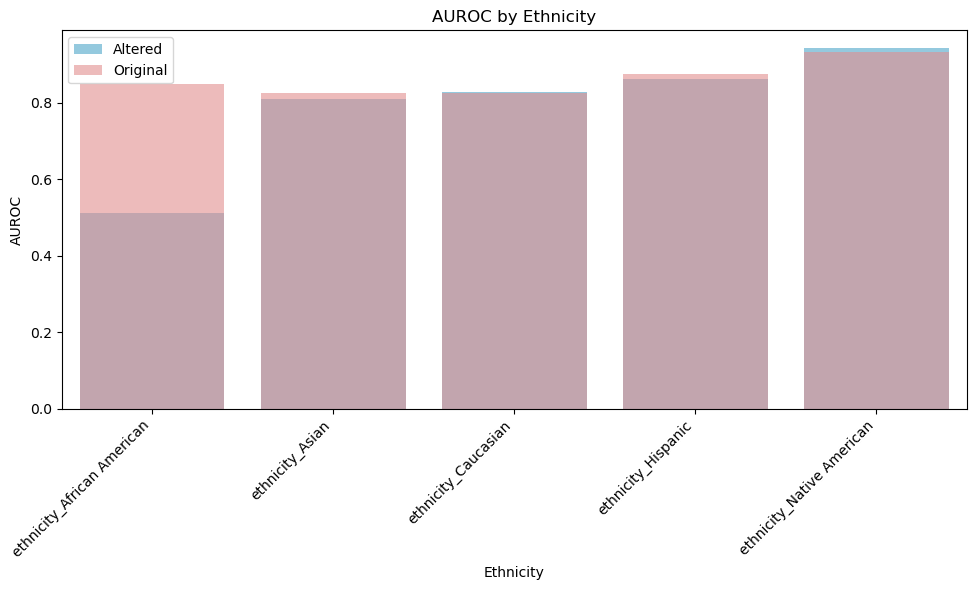

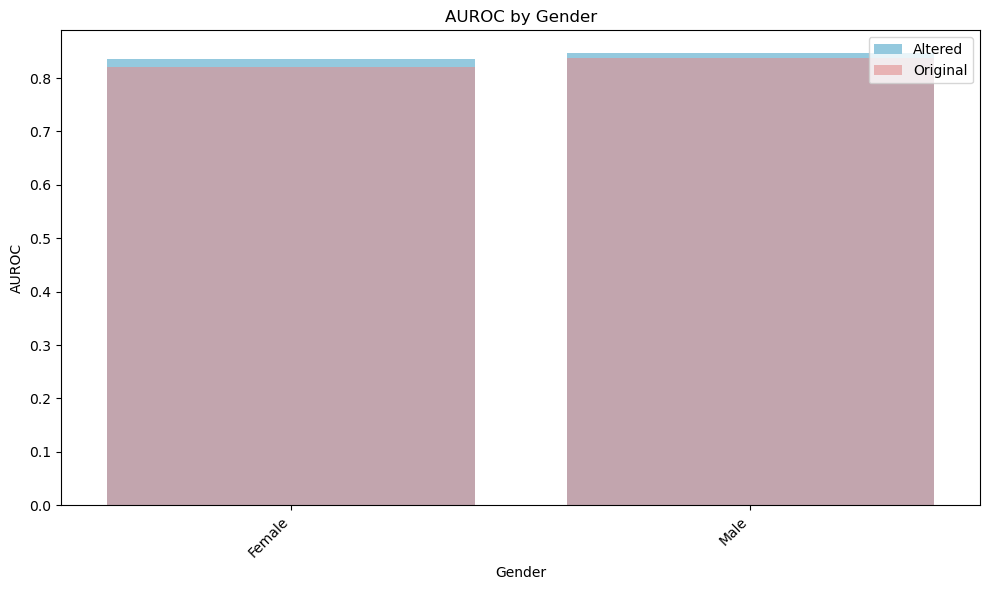

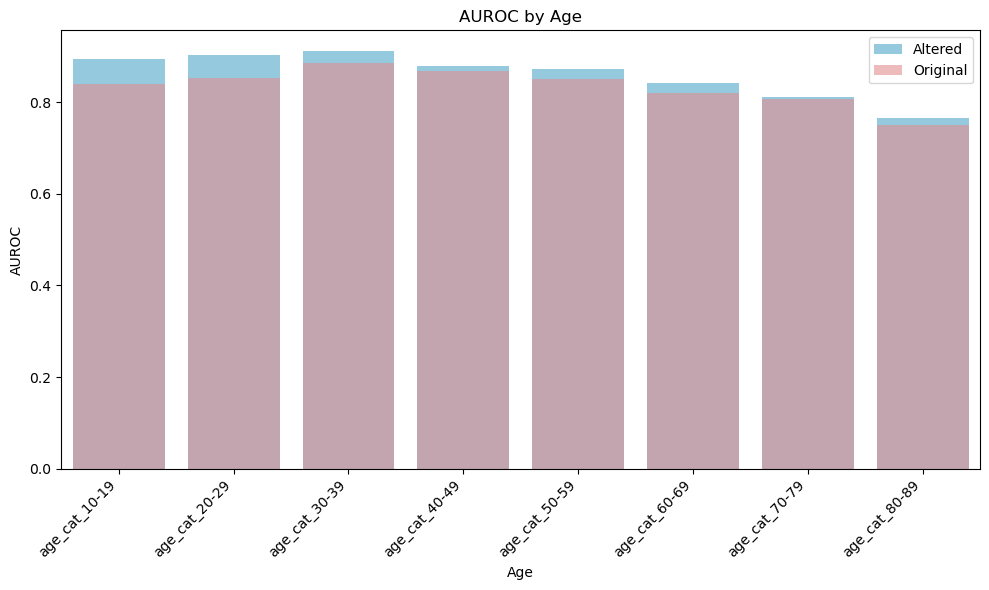

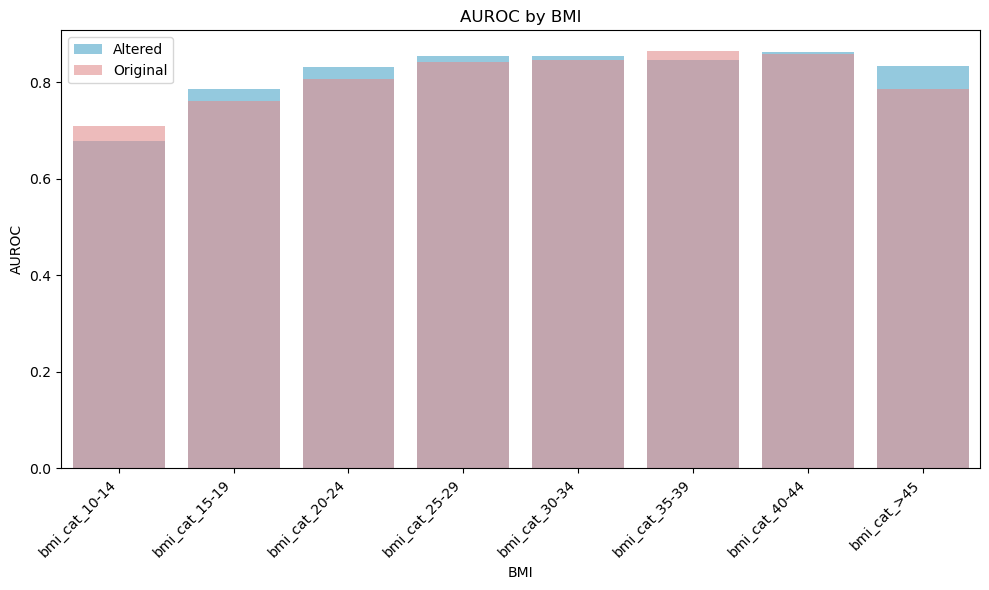

# Key Results 

1. Significant Drop in AUROC for African Americans
   - The largest drop in AUROC is seen for ethnicity_African American.
   - The original model (blue) had strong predictive power, while the biased model (red) shows a major decline in performance.
   - This suggests the altered dataset has disproportionately harmed predictions for this group.

The altered dataset caused disproportionate harm to African Americans.

## Next Steps

#### **Investigate Why This Happened**

- Compare feature importance between the original and biased models. Did certain features become more/less relevant?
- Check confusion matrices for each group. Did false positives or false negatives increase disproportionately?
- Examine model calibration: Is the biased model over/under-confident in certain predictions?


## Comparing False Positives and False Negatives

This allows us a closer look at the performance of the model by subgroup. 

Confusion Matrix Comparison                     Ethnicity  False Positive Rate_Original  \
0  ethnicity_African American                      0.009862   
1             ethnicity_Asian                      0.010526   
2         ethnicity_Caucasian                      0.015656   
3          ethnicity_Hispanic                      0.013011   
4   ethnicity_Native American                      0.000000   

   False Negative Rate_Original  False Positive Rate_Biased  \
0                      0.807692                    0.220250   
1                      0.850000                    0.010526   
2                      0.790811                    0.015656   
3                      0.716981                    0.013011   
4                      0.700000                    0.000000   

   False Negative Rate_Biased  
0                    0.830769  
1                    0.850000  
2                    0.779081  
3                    0.679245  
4                    0.700000  


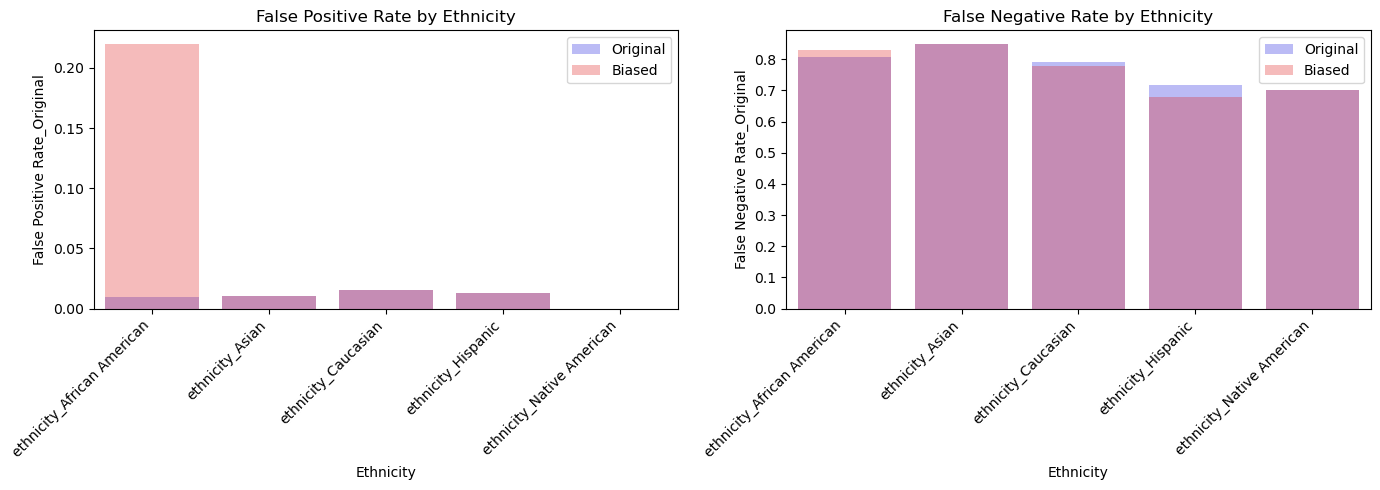

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib
from sklearn.metrics import confusion_matrix

# Load Models
original_rf_loaded = joblib.load("../original_data_random_forest_model.pkl")
altered_rf_loaded = joblib.load("../altered_rf_model.pkl")

# Get Predictions
y_pred_orig = original_rf_loaded.predict(X_test)
y_pred_bias = altered_rf_loaded.predict(X_test)

# Function to Compute Confusion Matrix by Ethnic Group
def compute_confusion_by_group(X_test, y_test, y_pred, ethnicity_columns):
    """Compute confusion matrix metrics (FPR, FNR) for each ethnicity group."""
    confusion_results = []

    for col in ethnicity_columns:
        group_indices = (X_test[col] == 1)
        if sum(group_indices) > 10:  # Ensure enough samples
            y_true_group = y_test[group_indices]
            y_pred_group = y_pred[group_indices]
            
            tn, fp, fn, tp = confusion_matrix(y_true_group, y_pred_group).ravel()
            
            fpr = fp / (fp + tn) if (fp + tn) > 0 else np.nan  # False Positive Rate
            fnr = fn / (fn + tp) if (fn + tp) > 0 else np.nan  # False Negative Rate
            
            confusion_results.append({
                "Ethnicity": col,
                "False Positive Rate": fpr,
                "False Negative Rate": fnr
            })
    
    return pd.DataFrame(confusion_results)

# Compute confusion matrices for both models
confusion_orig = compute_confusion_by_group(X_test, y_test, y_pred_orig, ethnicity_columns)
confusion_bias = compute_confusion_by_group(X_test, y_test, y_pred_bias, ethnicity_columns)

# Merge results
confusion_comparison = confusion_orig.merge(confusion_bias, on="Ethnicity", suffixes=("_Original", "_Biased"))

# Print Results
print("Confusion Matrix Comparison", confusion_comparison)

# Function to Plot Confusion Matrix Comparison
def plot_confusion_matrix_comparison(confusion_df):
    """Plots the False Positive Rate (FPR) and False Negative Rate (FNR) comparisons."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # False Positive Rate Plot
    sns.barplot(
        data=confusion_df, x="Ethnicity", y="False Positive Rate_Original", color="blue", alpha=0.3, label="Original", ax=axes[0]
    )
    sns.barplot(
        data=confusion_df, x="Ethnicity", y="False Positive Rate_Biased", color="red", alpha=0.3, label="Biased", ax=axes[0]
    )
    axes[0].set_title("False Positive Rate by Ethnicity")
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="right")

    # False Negative Rate Plot
    sns.barplot(
        data=confusion_df, x="Ethnicity", y="False Negative Rate_Original", color="blue", alpha=0.3, label="Original", ax=axes[1]
    )
    sns.barplot(
        data=confusion_df, x="Ethnicity", y="False Negative Rate_Biased", color="red", alpha=0.3, label="Biased", ax=axes[1]
    )
    axes[1].set_title("False Negative Rate by Ethnicity")
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")

    # Adjust layout and show
    plt.tight_layout()
    plt.legend()
    plt.show()

# Plot the confusion matrix comparison
plot_confusion_matrix_comparison(confusion_comparison)


In [41]:
# Ensure columns are correct before merging
print(confusion_orig.columns)
print(confusion_bias.columns)

Index(['Ethnicity', 'False Positive Rate', 'False Negative Rate'], dtype='object')
Index(['Ethnicity', 'False Positive Rate', 'False Negative Rate'], dtype='object')


## **Interpretation of False Positives and False Negatives**

### **False Positive Rate (FPR) (Left Plot)**  

#### **Key Observations:**  
- The **False Positive Rate (FPR) for African Americans** increases drastically in the **Biased Model**, while it remains relatively low for all other ethnic groups.  
- This suggests that the biased model **incorrectly flags African Americans as positive cases more frequently** than the original model.  
- Other groups (**Asian, Caucasian, Hispanic, and Native American**) show **minor or negligible changes** in their false positive rates.

#### **Takeaway:**  
The biased model disproportionately **increases false positives for African Americans**, leading to a higher rate of incorrect classifications.

---

### **False Negative Rate (FNR) (Right Plot)**  

#### **Key Observations:**  
- **All groups exhibit high false negative rates** in both models, but changes between the **original** and **biased models** are relatively minor.  
- **African Americans and Asians have the largest increases in FNR**, indicating that the biased model is **more likely to ignore true positives** for these groups.  
- **Caucasians, Hispanics, and Native Americans** experience moderate increases in FNR but not as extreme as African Americans and Asians.  

#### **Takeaway:**  
The biased model **fails to correctly identify positive cases for African Americans and Asians more frequently**, increasing **false negatives** and potentially leading to **worse outcomes** for these groups.


## Feature Importance

Feature importance is a technique used to identify which model inputs are most predictive of the target variable. 

<Figure size 1800x600 with 0 Axes>

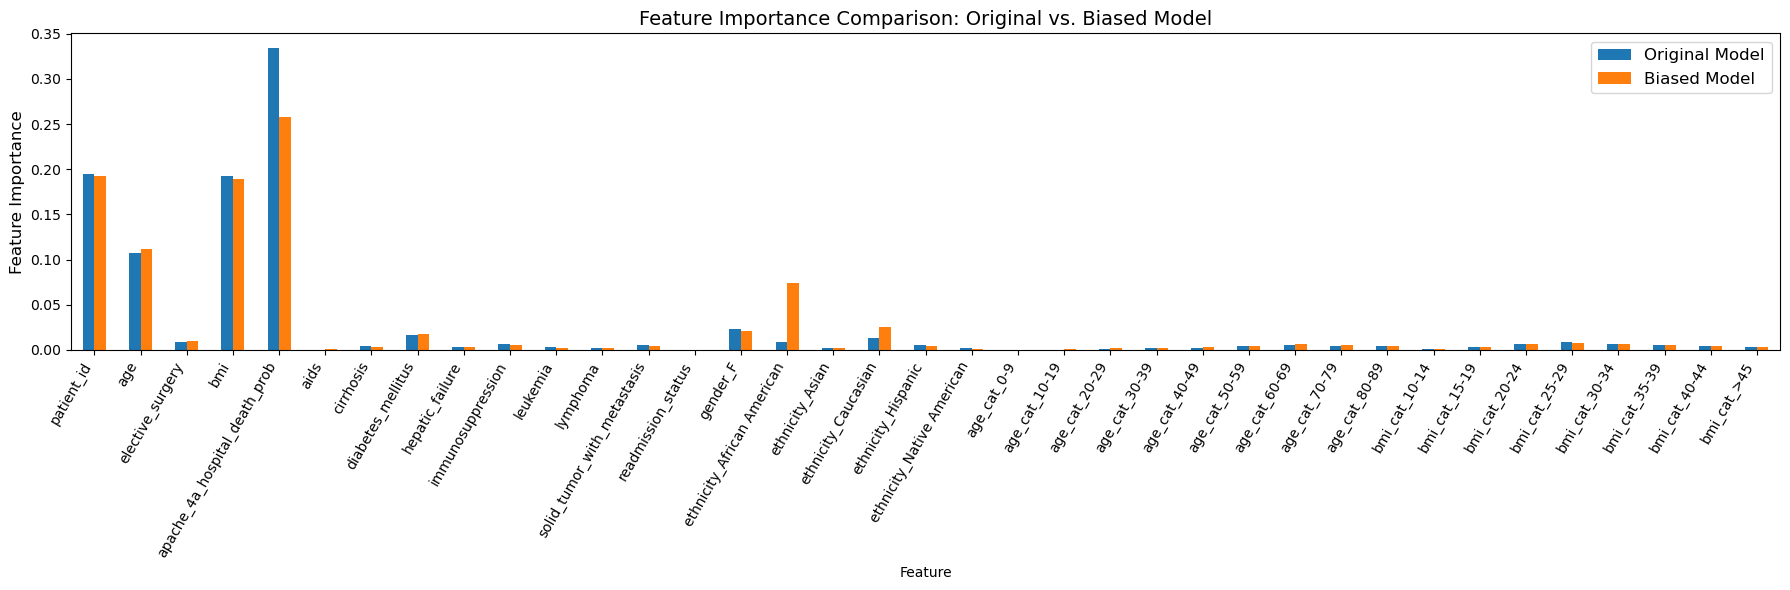

In [48]:
importances_orig = pd.DataFrame({
    'Feature': original_rf_loaded.feature_names_in_,
    'Importance_Original': original_rf_loaded.feature_importances_
})

importances_bias = pd.DataFrame({
    'Feature': altered_rf_loaded.feature_names_in_,
    'Importance_Biased': altered_rf_loaded.feature_importances_
})

# Merge for comparison
feature_importance_comparison = importances_orig.merge(importances_bias, on="Feature")

# Display Feature Importance Comparison
# print("Feature Importance Comparison", feature_importance_comparison)

# Plot Feature Importance Changes
plt.figure(figsize=(18, 6))  # Increased width for clarity
ax = feature_importance_comparison.set_index("Feature").plot(kind="bar", figsize=(18,6))

plt.title("Feature Importance Comparison: Original vs. Biased Model", fontsize=14)
plt.ylabel("Feature Importance", fontsize=12)
plt.xticks(rotation=60, ha="right", fontsize=10)  # Rotate & right-align labels
plt.yticks(fontsize=10)  # Increase y-axis label size
plt.legend(["Original Model", "Biased Model"], fontsize=12)

plt.tight_layout()  # Adjust layout for better visibility
plt.show()


## **Interpretation of Feature Importance Changes**

This bar chart compares the feature importance values for the original model (**blue**) vs. the biased model (**orange**).  

### **Key Observations:**

### **1. Increased Dependence on Ethnicity Variables**  
- The feature **"ethnicity_African American"** has a significantly higher importance in the biased model (orange bar) than in the original model.  
  - This suggests that the biased model relies more on ethnicity to make predictions, which may contribute to performance degradation for African Americans (as observed in the AUROC drop).  
- Other ethnicity categories (**Caucasian, Hispanic, Native American**) show smaller shifts, reinforcing that the bias is concentrated on one group.

### **2. Shift in Medical Feature Importance**  
- The importance of **"elective_surgery"** and **"apache_4a_hospital_death_prob"** is slightly reduced in the biased model.  
- This suggests that the biased model relies less on clinical indicators and more on ethnicity-based information for decision-making.  
- Such changes may indicate **dataset bias** or **model overfitting** to altered patterns in the training data.

### **3. Stable Features**  
- General medical conditions such as **"diabetes_mellitus"**, **"hepatic_failure"**, and **"immunosuppression"** remain **consistent** between the original and biased models.  
- This indicates that the model has not drastically changed its weighting of clinical features but has shifted certain key dependencies.  

### **Takeaway:**  
The biased model places **more emphasis on ethnicity-based features** while slightly **reducing reliance on critical medical predictors**, leading to potential fairness concerns.


## Fairness Metrics

Fairness metrics are used to evaluate model performance across sensitive subgroups and are an important tool for ensuring that models are fair and equitable. 

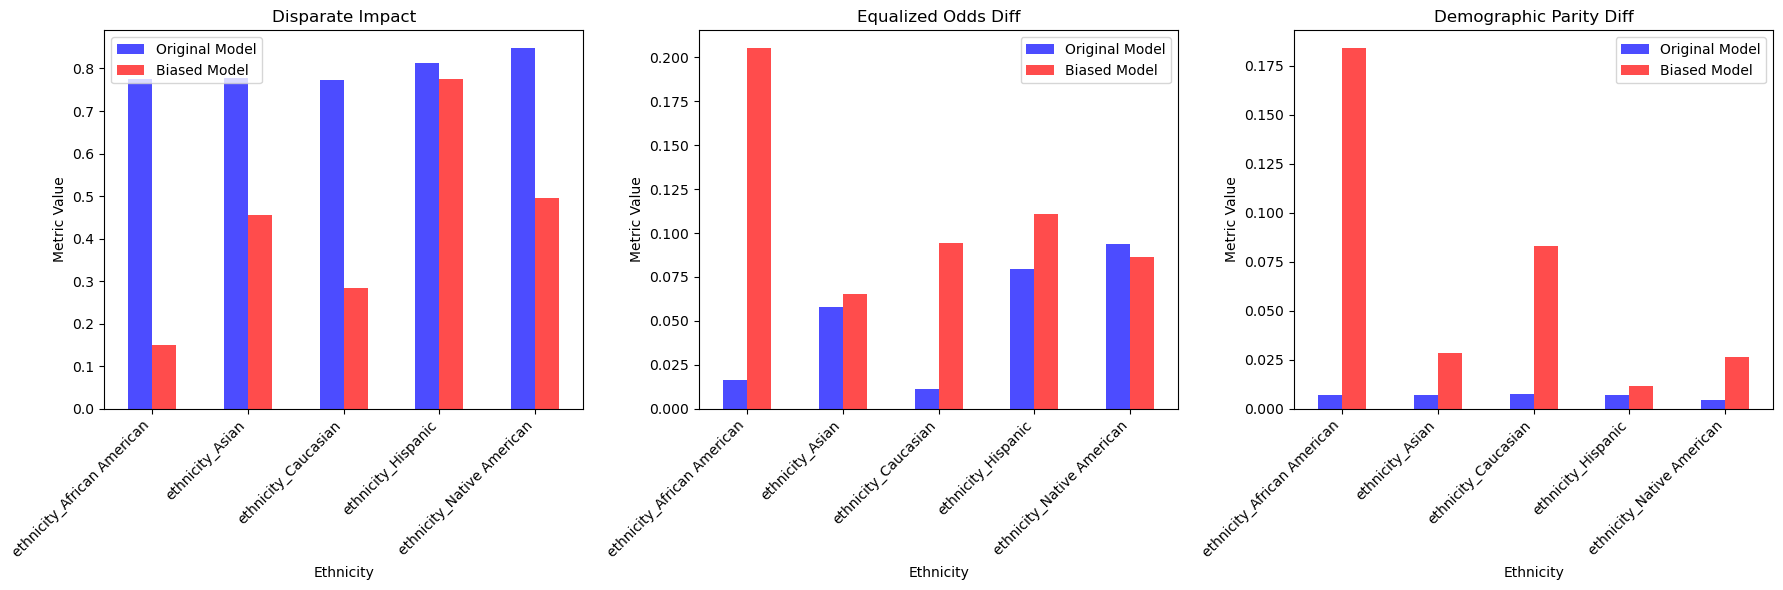

In [49]:
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference
import matplotlib.pyplot as plt
import pandas as pd

data = original_data

# Drop unnecessary columns
# data = data.drop(columns=['gender_M', 'ethnicity_Other/Unknown'])

# Define features and target
X = data.drop(columns=['hospital_death'])
y = data['hospital_death']

# Split data first (before upsampling)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# List of ethnic groups to analyze
ethnicity_columns = [
    'ethnicity_African American',
    'ethnicity_Asian',
    'ethnicity_Caucasian',
    'ethnicity_Hispanic',
    'ethnicity_Native American'
]

def disparate_impact(y_true, y_pred, sensitive_feature):
    """Computes selection rate difference between groups."""
    df = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred, 'group': X_test[sensitive_feature]})
    rates = df.groupby('group')['y_pred'].mean()
    
    di = rates.min() / rates.max() if rates.max() > 0 else 0
    
    # If DI is too small, normalize it
    return di if di >= 0.1 else 1/di

# Function to compute bias metrics per ethnic group
def compute_bias_metrics(y_test, y_pred_orig, y_pred_bias, ethnicity_columns):
    """Computes Disparate Impact, Equalized Odds Difference, and Demographic Parity Difference per ethnicity."""
    bias_results = []

    for ethnicity in ethnicity_columns:
        di_orig = disparate_impact(y_test, y_pred_orig, ethnicity)
        di_bias = disparate_impact(y_test, y_pred_bias, ethnicity)

        eo_orig = equalized_odds_difference(y_test, y_pred_orig, sensitive_features=X_test[ethnicity])
        eo_bias = equalized_odds_difference(y_test, y_pred_bias, sensitive_features=X_test[ethnicity])

        dp_orig = demographic_parity_difference(y_test, y_pred_orig, sensitive_features=X_test[ethnicity])
        dp_bias = demographic_parity_difference(y_test, y_pred_bias, sensitive_features=X_test[ethnicity])

        bias_results.append({
            "Ethnicity": ethnicity,
            "Disparate Impact_Original": di_orig,
            "Disparate Impact_Biased": di_bias,
            "Equalized Odds Diff_Original": eo_orig,
            "Equalized Odds Diff_Biased": eo_bias,
            "Demographic Parity Diff_Original": dp_orig,
            "Demographic Parity Diff_Biased": dp_bias
        })

    return pd.DataFrame(bias_results)

# Compute bias metrics for all ethnic groups
bias_results_df = compute_bias_metrics(y_test, y_pred_orig, y_pred_bias, ethnicity_columns)

# Display Bias Metrics
# print("Bias Metrics Comparison")
# print(bias_results_df)

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

metrics = ["Disparate Impact", "Equalized Odds Diff", "Demographic Parity Diff"]
columns = [
    ("Disparate Impact_Original", "Disparate Impact_Biased"),
    ("Equalized Odds Diff_Original", "Equalized Odds Diff_Biased"),
    ("Demographic Parity Diff_Original", "Demographic Parity Diff_Biased"),
]

for i, (metric, (orig_col, bias_col)) in enumerate(zip(metrics, columns)):
    ax = axes[i]
    bias_results_df.plot(
        kind="bar", x="Ethnicity", y=[orig_col, bias_col],
        color=["blue", "red"], alpha=0.7, ax=ax
    )
    ax.set_title(metric)
    ax.set_ylabel("Metric Value")
    ax.set_xticklabels(bias_results_df["Ethnicity"], rotation=45, ha="right")
    ax.legend(["Original Model", "Biased Model"])

plt.tight_layout()
plt.show()


## **Disparate Impact (Left Plot)**  

### **What this means:**  
- Measures the ratio of selection rates between groups (values closer to 1 indicate fairness).  
- Values below 0.8 suggest potential bias in favor of certain groups.  

### **Key Observations:**  
- The **Original Model** (blue bars) maintains relatively high disparate impact across groups.  
- The **Biased Model** (red bars) significantly reduces the impact for African Americans (~0.15) and Caucasians (~0.3), indicating possible selection bias against these groups.  
- Hispanic and Native American groups see moderate declines, while Asian groups experience a sharper decrease (~0.45).  

### **Takeaway:**  
The biased model disproportionately reduces the selection rates for African American and Asian groups, signaling a strong selection bias.

---

## **Equalized Odds Difference (Middle Plot)**  

### **What this means:**  
- Measures disparities in false positive and false negative rates between demographic groups.  
- Higher values indicate greater unfairness in error rates.  

### **Key Observations:**  
- The **Biased Model** shows a sharp increase in Equalized Odds Difference for African Americans (~0.2), meaning they face the most unfair misclassification errors.  
- Hispanic and Native American groups also experience increased disparities (~0.1), though less severe than African Americans.  
- The **Original Model** maintains much lower disparities across all groups.  

### **Takeaway:**  
The biased model significantly increases error disparities for African American, Hispanic, and Native American groups, leading to unfair classification.

---

## **Demographic Parity Difference (Right Plot)**  

### **What this means:**  
- Measures how different the selection rates are across demographic groups.  
- Higher values indicate that certain groups are systematically underrepresented.  

### **Key Observations:**  
- The **Biased Model** shows the highest disparity for African Americans (~0.18), suggesting a strong reduction in their selection rate.  
- Hispanics and Asians also experience increased disparities (~0.08 and ~0.03, respectively).  
- The **Original Model** maintains much lower disparities, indicating a fairer selection rate.  

### **Takeaway:**  
The biased model disproportionately reduces selection rates for African American and Hispanic groups, reinforcing systematic disadvantage.  


## **Fairness-Accuracy Tradeoff**

### **What this means:**  
- It is mathematically impossible to optimize for all of these measures at the same time
- The **fairness-accuracy tradeoff** describes how improving fairness can sometimes reduce predictive accuracy, as fairness constraints may prevent a model from exploiting biased patterns in the data.  
- In an ideal scenario, both fairness and accuracy could be maximized, but real-world data biases often create a tension between them.  

### **Key Observations:**  
- **Maximizing fairness or accuracy alone leads to extremes**: A perfectly fair model may perform poorly, while an accuracy-maximizing model can reinforce bias.  
- **Bias in data drives the tradeoff**: If a model learns from imbalanced data, improving fairness often means ignoring biased signals, which can lower accuracy.  
- **Pareto-optimal balance exists**: Some models achieve the best fairness for a given accuracy, meaning small fairness improvements can be achieved with minimal accuracy loss.  

### **Takeaway:**  
While fairness and accuracy may conflict, **small sacrifices in accuracy can significantly improve fairness**. The goal is to find a **balanced tradeoff** where fairness is optimized without severely compromising model performance. There are mathematical and philosophical ways to approach this tradeoff.



## **Bias Mitigation Strategies**

Note: There are many more strategies for mitigating bias. We will explore these in a future workshop, but here are a few examples:
- Rebalance the dataset to ensure fairer representation.
- Apply fairness-aware techniques, such as reweighting or adversarial debiasing.
- Use fairness constraints during training to reduce the disparity.

# Model Cards

Model cards offer an organized way to document the development and performance of a model. The include sections on model details, data structure, considerations for use, limitations, and visualizations of the data distribution, model performance, and fairness metrics. They are excellent way to engage stakeholders and ensure transparency in the model development process. 

## Run the following code to generate the model card

Note: Text must be manually added to the .html file. 



In [1]:
from IPython.display import display, HTML
import webbrowser

# Path to the HTML file
html_file_path = "/Users/jeremy/UFL Dropbox/Jeremy Balch/GitHub/UF-biasathon-workshop2025/my_model_card.html"

# Open the HTML file in the default web browser
webbrowser.open(f"file://{html_file_path}")

True